In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, auc, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import re
import string
import pickle
import joblib
from sklearn import metrics
import os
import gensim


#### Read The Data

In [2]:
class_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

train = pd.read_csv('C:/Users/Shendy/Desktop/Project_Draft/ToxiCommentClassification/train.csv')
test = pd.read_csv('C:/Users/Shendy/Desktop/Project_Draft/ToxiCommentClassification/test.csv')

#### Cleaning Data

In [3]:
#remove non-ascii characters
def remove_non_ascii(text):
    # checking whether the char is printable value 
    text  = "".join([char for char in text if char in string.printable])
    # remove a match for any digit between 0 and 9
    text = re.sub('[0-9]+', '', text)
    return text
train['comment_text'] = train['comment_text'].apply(lambda x: remove_non_ascii(x))
test['comment_text'] = test['comment_text'].apply(lambda x: remove_non_ascii(x))

In [4]:
remove_non_ascii('éñtesting123214ßŁ')

'testing'

In [5]:
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']
all_text = pd.concat([list_sentences_train, list_sentences_test])

In [6]:
list_sentences_train

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [7]:
#separate comments into ones where each class name = 1

toxic = list_sentences_train.loc[train['toxic'] == 1]
severe_toxic = list_sentences_train.loc[train['severe_toxic'] == 1]
obscene = list_sentences_train.loc[train['obscene'] == 1]
threat = list_sentences_train.loc[train['threat'] == 1]
insult = list_sentences_train.loc[train['insult'] == 1]
identity_hate = list_sentences_train.loc[train['identity_hate'] == 1]

In [8]:
toxic.head()

6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12    Hey... what is it..\n@ | talk .\nWhat is it......
16    Bye! \n\nDon't look, come or think of comming ...
42    You are gay or antisemmitian? \n\nArchangel WH...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
Name: comment_text, dtype: object

In [9]:
# Remove/change stopwords
cl_path = 'C:/Users/Shendy/Desktop/Project_Draft/Chat_Classifier/static/cleaning/clean_letters.txt'
clean_word_dict = {} #clean_letters.txt
with open(cl_path, 'r', encoding='utf-8') as cl:
    for line in cl:
        line = line.strip('\n')
        typo, correct = line.split(',')
        clean_word_dict[typo] = correct

def clean_word(text):
    replace_numbers = re.compile(r'\d+', re.IGNORECASE)
    special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

    text = text.lower()
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)

    for typo, correct in clean_word_dict.items(): # corecting typo
        text = re.sub(typo, " " + correct + " ", text) 

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    return text

In [10]:
toxic[42]

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [11]:
clean_word(toxic[42])

'you are gay or antisemmitian? archangel white tiger meow ! greetingshhh ! uh there are two ways why you do erased my comment about ww that holocaust was brutally slaying of jews and not gays gypsys slavs anyone - if you are anti - semitian than shave your head bald and go to the skinhead meetings ! - if you doubt words of the bible that homosexuality is a deadly sin make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals ! - first and last warning you fucking gay - i wo not appreciate if any more nazi shwain would write in my page ! i do not wish to talk to you anymore ! beware of the dark side ! '

In [12]:
train_text = []
test_text = []
toxic_text = []
severe_toxic_text = []
obscene_text = []
threat_text = []
insult_text = []
identity_hate_text = []

for text in list_sentences_train:
    train_text.append(clean_word(text))
    
for text in list_sentences_test:
    test_text.append(clean_word(text))
    
for text in toxic:
    toxic_text.append(clean_word(text))

for text in severe_toxic_text:
    severe_toxic_text.append(clean_word(text))

for text in obscene_text:
    obscene_text.append(clean_word(text))

for text in threat:
    threat_text.append(clean_word(text))

for text in insult:
    insult_text.append(clean_word(text))

for text in identity_hate:
    identity_hate_text.append(clean_word(text))

In [13]:
train_text[:5]

['explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now ',
 'd aww ! he matches this background colour i am seemingly stuck with thanks (talk) : january (utc)',
 'hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info ',
 '"\nmore\ni cannot make any real suggestions on improvement - i wondered if the section statistics should be later on or a subsection of ""types of accidents"" - i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no - one else does first - if you have any preferences for formatting style on references or want to do it your

### Apply TF-IDF Vectorizer

In [14]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    ngram_range = (1, 1),
    stop_words = 'english',
    max_features = 20000)
word_vectorizer.fit(all_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [41]:
#word_vectorizer.vocabulary_

In [47]:
for key, value in word_vectorizer.vocabulary_.items():
    if value == 301:
        print(key)

admixture


In [39]:
# word_vectorizer.get_feature_names()

In [16]:
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [17]:
train_word_features

<159571x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 3567616 stored elements in Compressed Sparse Row format>

### Apply CountVectorizers

In [18]:
## Convert a collection of text documents to a matrix of token counts (sparse matrix)
def create_df_of_toxic_category(category_string):
    '''category string must match train dataframe column name exactly ''' 
    filtered_sentences = list_sentences_train.loc[train[category_string] == 1]
    category_vectorizer = CountVectorizer(
        strip_accents = 'unicode',
        analyzer = 'word',
        ngram_range = (1, 1),
        stop_words = 'english',
        max_features = 20000)
    category_vec_fit = category_vectorizer.fit(filtered_sentences)

    category_count_features = category_vectorizer.transform(filtered_sentences)
    category_count_df = pd.DataFrame(category_vec_fit.get_feature_names())
    category_count_df['counts'] = category_count_features.toarray().sum(axis=0)
    category_count_df.rename(columns = {0: 'word'})
    return category_count_df, filtered_sentences

In [19]:
class_specific_vocab_dict = dict()
class_specific_sentences = dict()
for class_name in class_names:
    class_specific_vocab_dict[class_name] =\
        create_df_of_toxic_category(class_name)[0].sort_values('counts', ascending = False)
    class_specific_sentences[class_name] =\
        create_df_of_toxic_category(class_name)[1]

In [20]:
class_specific_vocab_dict['toxic']

,0,counts
5516,fuck,9937
19099,wikipedia,3677
13998,shit,3624
8059,like,3512
9314,nigger,3300
...,...,...
14647,smileys,1
14642,smerf,1
14638,smelllllllly,1
14634,smegma,1


### Train test split

In [21]:
#train test split for each Class
X_train_toxic, X_test_toxic, y_train_toxic, y_test_toxic = train_test_split(
    train_word_features,train['toxic'], test_size=0.2, random_state=42)

X_train_severe_toxic, X_test_severe_toxic, y_train_severe_toxic, y_test_severe_toxic = train_test_split(
    train_word_features,train['severe_toxic'], test_size=0.2, random_state=42)

X_train_obscene, X_test_obscene, y_train_obscene, y_test_obscene = train_test_split(
    train_word_features,train['obscene'], test_size=0.2, random_state=42)

X_train_threat, X_test_threat, y_train_threat, y_test_threat = train_test_split(
    train_word_features,train['threat'], test_size=0.2, random_state=42)

X_train_insult, X_test_insult, y_train_insult, y_test_insult = train_test_split(
    train_word_features,train['insult'], test_size=0.2, random_state=42)

X_train_identity_hate, X_test_identity_hate, y_train_identity_hate, y_test_identity_hate = train_test_split(
    train_word_features,train['identity_hate'], test_size=0.2, random_state=42)

In [22]:
print(X_train_toxic.shape)
print(X_test_toxic.shape)
print(y_train_toxic.shape)
print(y_test_toxic.shape)

(127656, 20000)
(31915, 20000)
(127656,)
(31915,)


## Modeling

### 1.Naive Bayes Classifier for Multinomial

In [23]:
# Toxic
NB_tox = MultinomialNB()
NB_tox.fit(X_train_toxic, y_train_toxic)
predictTrain_tox = NB_tox.predict(X_train_toxic)
print(predictTrain_tox)

# Severe Toxic
NB_stox = MultinomialNB()
NB_stox.fit(X_train_severe_toxic, y_train_severe_toxic)
predictTrain_stox = NB_stox.predict(X_train_severe_toxic)
print(predictTrain_stox)

# Obscene
NB_obs = MultinomialNB()
NB_obs.fit(X_train_obscene, y_train_obscene)
predictTrain_obs = NB_obs.predict(X_train_obscene)
print(predictTrain_obs)

# Threat
NB_threat = MultinomialNB()
NB_threat.fit(X_train_threat, y_train_threat)
predictTrain_threat = NB_obs.predict(X_train_threat)
print(predictTrain_threat)

# Insult
NB_insult = MultinomialNB()
NB_insult.fit(X_train_insult, y_train_insult)
predictTrain_insult = NB_obs.predict(X_train_insult)
print(predictTrain_insult)

# Indentity Hate
NB_identity = MultinomialNB()
NB_identity.fit(X_train_identity_hate, y_train_identity_hate)
predictTrain_identity = NB_obs.predict(X_train_identity_hate)
print(predictTrain_identity)

[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


## Model Evaluation (Training Data)

In [24]:
con_tox = pd.DataFrame(data = confusion_matrix(y_train_toxic,predictTrain_tox), columns=['Pred Clean', 'Pred Toxic'], index=['Actual Clean', 'Actual Toxic'])
con_stox = pd.DataFrame(data = confusion_matrix(y_train_severe_toxic,predictTrain_stox), columns=['Pred Clean', 'Pred Severe Toxic'], index=['Actual Clean', 'Actual Severe Toxic'])
con_obs = pd.DataFrame(data = confusion_matrix(y_train_obscene,predictTrain_obs), columns=['Pred Clean', 'Pred Obscene'], index=['Actual Clean', 'Actual Obscene'])
con_threat = pd.DataFrame(data = confusion_matrix(y_train_threat,predictTrain_threat), columns=['Pred Clean', 'Pred Threat'], index=['Actual Clean', 'Actual Threat'])
con_insult = pd.DataFrame(data = confusion_matrix(y_train_insult,predictTrain_insult), columns=['Pred Clean', 'Pred Insult'], index=['Actual Clean', 'Actual Insult'])
con_identity = pd.DataFrame(data = confusion_matrix(y_train_identity_hate,predictTrain_identity), columns=['Pred Clean', 'Pred Indentity Hate'], index=['Actual Clean', 'Indentity Hate'])

print('-'*10,'Confusion Matrix & Classification Report','-'*10)
print(con_tox)
print(classification_report(y_train_toxic,predictTrain_tox))
print('-'*60)
print(con_stox)
print(classification_report(y_train_severe_toxic,predictTrain_stox))
print('-'*60)
print(con_obs)
print(classification_report(y_train_obscene,predictTrain_obs))
print('-'*60)
print(con_threat)
print(classification_report(y_train_threat,predictTrain_threat))
print('-'*60)
print(con_insult)
print(classification_report(y_train_insult,predictTrain_insult))
print('-'*60)
print(con_identity)
print(classification_report(y_train_identity_hate,predictTrain_identity))

---------- Confusion Matrix & Classification Report ----------
              Pred Clean  Pred Toxic
Actual Clean      115024         394
Actual Toxic        5907        6331
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    115418
           1       0.94      0.52      0.67     12238

    accuracy                           0.95    127656
   macro avg       0.95      0.76      0.82    127656
weighted avg       0.95      0.95      0.94    127656

------------------------------------------------------------
                     Pred Clean  Pred Severe Toxic
Actual Clean             126367                 15
Actual Severe Toxic        1227                 47
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    126382
           1       0.76      0.04      0.07      1274

    accuracy                           0.99    127656
   macro avg       0.87      0.52      0.53    127656
weighted avg 

### 2. Logistic Regression

In [25]:
# Toxic
LR_tox = LogisticRegression(solver='sag')
LR_tox.fit(X_train_toxic, y_train_toxic)
predictTrain_tox = LR_tox.predict(X_train_toxic)
print(predictTrain_tox)

# Severe Toxic
LR_stox = LogisticRegression(solver='sag')
LR_stox.fit(X_train_severe_toxic, y_train_severe_toxic)
predictTrain_stox = LR_stox.predict(X_train_severe_toxic)
print(predictTrain_stox)

# Obscene
LR_obs = LogisticRegression(solver='sag')
LR_obs.fit(X_train_obscene, y_train_obscene)
predictTrain_obs = LR_obs.predict(X_train_obscene)
print(predictTrain_obs)

# Threat
LR_threat = LogisticRegression(solver='sag')
LR_threat.fit(X_train_threat, y_train_threat)
predictTrain_threat = LR_tox.predict(X_train_threat)
print(predictTrain_threat)

# Insult
LR_insult = LogisticRegression(solver='sag')
LR_insult.fit(X_train_insult, y_train_insult)
predictTrain_insult = LR_insult.predict(X_train_insult)
print(predictTrain_insult)

# Indentity Hate
LR_identity = LogisticRegression(solver='sag')
LR_identity.fit(X_train_identity_hate, y_train_identity_hate)
predictTrain_identity = LR_tox.predict(X_train_toxic)
print(predictTrain_identity)

[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


## Model Evaluation (Training Data)

In [26]:
con_tox = pd.DataFrame(data =confusion_matrix(y_train_toxic,predictTrain_tox), columns=['Pred Clean', 'Pred Toxic'], index=['Actual Clean', 'Actual Toxic'])
con_stox = pd.DataFrame(data = confusion_matrix(y_train_severe_toxic,predictTrain_stox), columns=['Pred Clean', 'Pred SToxic'], index=['Actual Clean', 'Actual SToxic'])
con_obs = pd.DataFrame(data =confusion_matrix(y_train_obscene,predictTrain_obs), columns=['Pred Clean', 'Pred Obscene'], index=['Actual Clean', 'Actual Obscene'])
con_threat = pd.DataFrame(data = confusion_matrix(y_train_threat,predictTrain_threat), columns=['Pred Clean', 'Pred Threat'], index=['Actual Clean', 'Actual Threat'])
con_insult = pd.DataFrame(data = confusion_matrix(y_train_insult,predictTrain_insult), columns=['Pred Clean', 'Pred Insult'], index=['Actual Clean', 'Actual Insult'])
con_identity = pd.DataFrame(data =confusion_matrix(y_train_identity_hate,predictTrain_identity), columns=['Pred Clean', 'Pred Identity Hate'], index=['Actual Clean', 'Actual Identity Hate'])

print('-'*10,'Confusion Matrix & Classification Report','-'*10)
print(con_tox)
print(classification_report(y_train_toxic,predictTrain_tox))
print('-'*60)
print(con_stox)
print(classification_report(y_train_severe_toxic,predictTrain_stox))
print('-'*60)
print(con_obs)
print(classification_report(y_train_obscene,predictTrain_obs))
print('-'*60)
print(con_threat)
print(classification_report(y_train_threat,predictTrain_threat))
print('-'*60)
print(con_insult)
print(classification_report(y_train_insult,predictTrain_insult))
print('-'*60)
print(con_identity)
print(classification_report(y_train_identity_hate,predictTrain_identity))

---------- Confusion Matrix & Classification Report ----------
              Pred Clean  Pred Toxic
Actual Clean      114944         474
Actual Toxic        4479        7759
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    115418
           1       0.94      0.63      0.76     12238

    accuracy                           0.96    127656
   macro avg       0.95      0.81      0.87    127656
weighted avg       0.96      0.96      0.96    127656

------------------------------------------------------------
               Pred Clean  Pred SToxic
Actual Clean       126171          211
Actual SToxic         950          324
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    126382
           1       0.61      0.25      0.36      1274

    accuracy                           0.99    127656
   macro avg       0.80      0.63      0.68    127656
weighted avg       0.99      0.99      0.99    12

## Model Evaluation (Testing Data)

In [27]:
predictTest_tox = LR_tox.predict(X_test_toxic)
print(predictTest_tox)

predictTest_stox = LR_stox.predict(X_test_severe_toxic)
print(predictTest_stox)

predictTest_obs = LR_obs.predict(X_test_obscene)
print(predictTest_obs)

predictTest_threat = LR_threat.predict(X_test_threat)
print(predictTest_threat)

predictTest_insult = LR_insult.predict(X_test_insult)
print(predictTest_insult)

predictTest_identity = LR_insult.predict(X_test_identity_hate)
print(predictTest_identity)

[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [28]:
con_tox = pd.DataFrame(data = confusion_matrix(y_test_toxic,predictTest_tox), columns=['Pred Clean', 'Pred Toxic'], index=['Actual Clean', 'Actual Toxic'])
con_stox = pd.DataFrame(data = confusion_matrix(y_test_severe_toxic,predictTest_stox), columns=['Pred Clean', 'Pred Severe Toxic'], index=['Actual Clean', 'Actual Severe Toxic'])
con_obs = pd.DataFrame(data = confusion_matrix(y_test_obscene,predictTest_obs), columns=['Pred Clean', 'Pred Obscene'], index=['Actual Clean', 'Actual Obscene'])
con_threat = pd.DataFrame(data = confusion_matrix(y_test_threat,predictTest_threat), columns=['Pred Clean', 'Pred Threat'], index=['Actual Clean', 'Actual Threat'])
con_insult = pd.DataFrame(data = confusion_matrix(y_test_insult,predictTest_insult), columns=['Pred Clean', 'Pred Insult'], index=['Actual Clean', 'Actual Insult'])
con_identity = pd.DataFrame(data = confusion_matrix(y_test_identity_hate,predictTest_identity), columns=['Pred Clean', 'Pred Identity'], index=['Actual Clean', 'Actual Identity'])

print('-'*20,'Confusion Matrix','-'*20)
print(con_tox)
print(classification_report(y_test_toxic,predictTest_tox))

print('-'*60)
print(con_stox)
print(classification_report(y_test_severe_toxic,predictTest_stox))

print('-'*60)
print(con_obs)
print(classification_report(y_test_obscene,predictTest_obs))

print('-'*60)
print(con_threat)
print(classification_report(y_test_threat,predictTest_threat))

print('-'*60)
print(con_insult)
print(classification_report(y_test_insult,predictTest_insult))

print('-'*60)
print(con_identity)
print(classification_report(y_test_identity_hate,predictTest_identity))

-------------------- Confusion Matrix --------------------
              Pred Clean  Pred Toxic
Actual Clean       28690         169
Actual Toxic        1228        1828
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.92      0.60      0.72      3056

    accuracy                           0.96     31915
   macro avg       0.94      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915

------------------------------------------------------------
                     Pred Clean  Pred Severe Toxic
Actual Clean              31535                 59
Actual Severe Toxic         242                 79
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.57      0.25      0.34       321

    accuracy                           0.99     31915
   macro avg       0.78      0.62      0.67     31915
weighted avg     

#### Plot ROC Curves

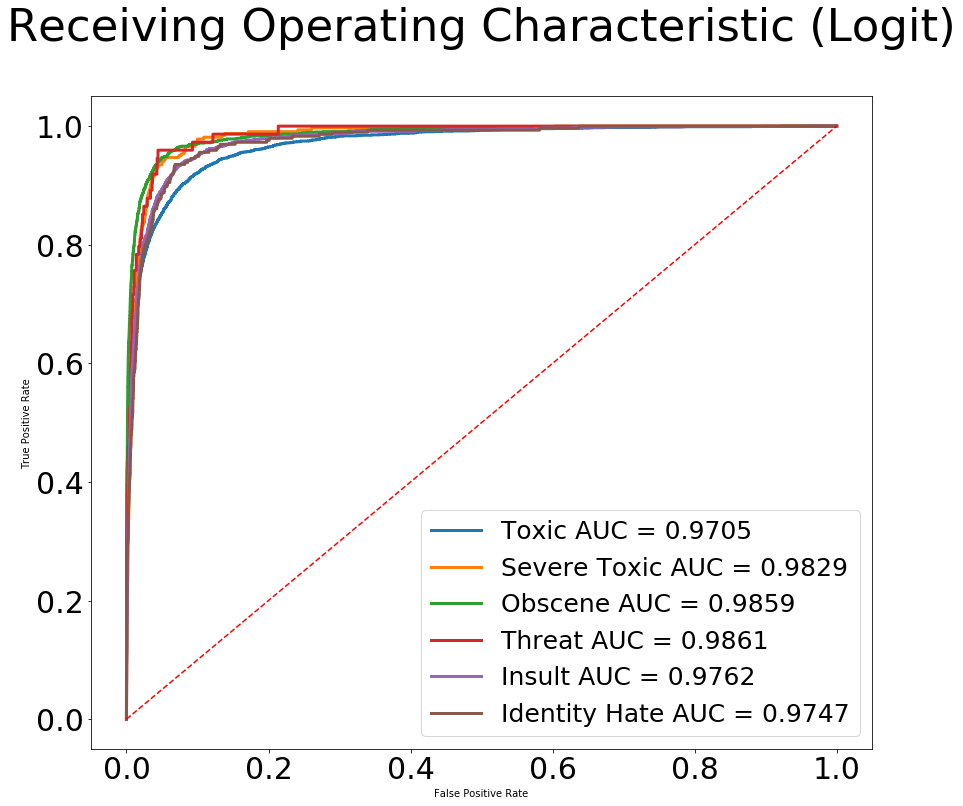

In [29]:
# Plot ROC Curves on out of sample data
fig, ax = plt.subplots(figsize=(14,12))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.rcParams.update({'font.size': 30})

y_pred_toxic = list(LR_tox.predict_proba(X_test_toxic)[:,1])
label_toxic = y_test_toxic
fpr, tpr, thresh = metrics.roc_curve(label_toxic, y_pred_toxic)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Toxic AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_severe_toxic = list(LR_stox.predict_proba(X_test_severe_toxic)[:,1])
label_severe_toxic = y_test_severe_toxic
fpr, tpr, thresh = metrics.roc_curve(label_severe_toxic, y_pred_severe_toxic)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Severe Toxic AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_obscene = list(LR_obs.predict_proba(X_test_obscene)[:,1])
label_obscene = y_test_obscene
fpr, tpr, thresh = metrics.roc_curve(label_obscene, y_pred_obscene)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Obscene AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_threat = list(LR_threat.predict_proba(X_test_threat)[:,1])
label_threat = y_test_threat
fpr, tpr, thresh = metrics.roc_curve(label_threat, y_pred_threat)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Threat AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_insult = list(LR_insult.predict_proba(X_test_insult)[:,1])
label_insult = y_test_insult
fpr, tpr, thresh = metrics.roc_curve(label_insult, y_pred_insult)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Insult AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_identity_hate = list(LR_identity.predict_proba(X_test_identity_hate)[:,1])
label_identity_hate = y_test_identity_hate
fpr, tpr, thresh = metrics.roc_curve(label_identity_hate, y_pred_identity_hate)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Identity Hate AUC = %0.4f" %roc_auc),linewidth=3.0)

plt.title('Receiving Operating Characteristic (Logit)\n',fontsize=45);
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0,prop={'size': 25});

<h5>-The area under the ROC curve tells us how many more false positives we get if we change our probability threshold to get more true positives.<\h5>
<h5>-In the context of this project, a false positive is saying a comment is toxic when it really is not, and a true positive is correctly identifying a toxic comment.<\h5>
<h5>-Basically, more area under the ROC curve means we get fewer additional false positives for additional true positives, which is what we want to maximize.<\h5>



### Model Dict

In [30]:
model_all = { 'toxic' : LR_tox,
         'severe_toxic' : LR_stox,
         'obscene' : LR_obs,
         'threat' : LR_threat,
         'insult' : LR_insult,
         'identity_hate' : LR_identity
}

In [31]:
model_all

{'toxic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False),
 'severe_toxic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False),
 'obscene': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
             

#### Save Model

In [32]:
#pickle the models
# Save Model as a pickle Using joblib
# Save the model as a pickle in a file 
joblib.dump(model_all, 'Logistic_Regression_models.p')
pickle.dump(word_vectorizer.fit(all_text), open("log_word_vectorizer.p", "wb"))

In [33]:
# Load the model from the file 
model_dict_imported = joblib.load('Logistic_Regression_models.p') 
word_vectorizer = joblib.load('log_word_vectorizer.p')
model_dict = model_dict_imported

#### Testing Input Chat with the Model

In [34]:
def raw_chat_to_model_input(raw_input_string):
    
    cleaned_text = []
    for text in [raw_input_string]:
        cleaned_text.append(clean_word(text))
    print(cleaned_text)
    return word_vectorizer.transform(cleaned_text)

    
def predict_toxicity(raw_input_string):
    model_input = raw_chat_to_model_input(raw_input_string)
    results = []
    for key,model in model_dict.items():
        results.append(round(model.predict_proba(model_input)[0,1],4))
    return results

In [35]:
chat_input = 'Hello world'

output_list = [list(model_dict.keys()),predict_toxicity(chat_input)]
for index in range(len(output_list[0])):
    print(output_list[0][index],output_list[1][index])

['hello world']
toxic 0.0582
severe_toxic 0.0065
obscene 0.0218
threat 0.0068
insult 0.0749
identity_hate 0.0176
